# Attention with Encoder-Decoder Recurrent Architecture
## Dr. Ankur Mali
## USF NLP 2025

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.X2UOKF_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.X2UOKF_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.X2UOKF_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.

Training with Bahdanau Attention
Epoch 1 Batch 0 Loss 4.1495
Epoch 1 Loss 3.2299
Epoch 2 Batch 0 Loss 2.9376
Epoch 2 Loss 2.8634
Epoch 3 Batch 0 Loss 2.7561
Epoch 3 Loss 2.7607
Epoch 4 Batch 0 Loss 2.6576
Epoch 4 Loss 2.6629
Epoch 5 Batch 0 Loss 2.4453
Epoch 5 Loss 2.5264
Epoch 6 Batch 0 Loss 2.5527
Epoch 6 Loss 2.4181
Epoch 7 Batch 0 Loss 2.4177
Epoch 7 Loss 2.3614
Epoch 8 Batch 0 Loss 2.4095
Epoch 8 Loss 2.2922
Epoch 9 Batch 0 Loss 2.2637
Epoch 9 Loss 2.2559
Epoch 10 Batch 0 Loss 2.2273
Epoch 10 Loss 2.2250

Training with Luong Attention
Epoch 1 Batch 0 Loss 4.0890
Epoch 1 Loss 3.2505
Epoch 2 Batch 0 Loss 2.8229
Epoch 2 Loss 2.8503
Epoch 3 Batch 0 Loss 2.7564
Epoch 3 Loss 2.7358
Epoch 4 Batch 0 Loss 2.6730
Epoch 4 Loss 2.5924
Epoch 5 Batch 0 Loss 2.6491
Epoch 5 Loss 2.4809
Epoch 6 Batch 0 Loss 2.5597
Epoch 6 Loss 2.4374
Epoch 7 Bat

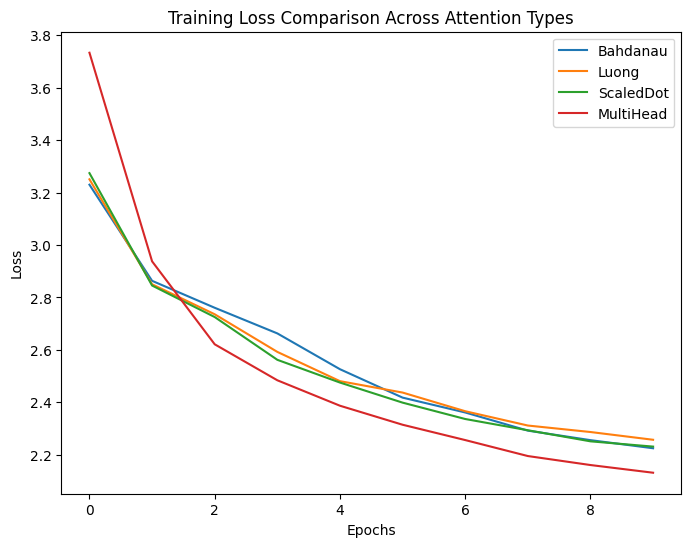

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. Various Attention Layer Implementations
# ===============================

# (a) Bahdanau (Additive) Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)  # for decoder hidden state
        self.W2 = tf.keras.layers.Dense(units)  # for encoder output
        self.V = tf.keras.layers.Dense(1)       # for computing score

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, tf.squeeze(attention_weights, -1)

# (b) Luong (Multiplicative) Attention
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongAttention, self).__init__()

    def call(self, query, values):
        query = tf.expand_dims(query, 1)  # (batch_size, 1, hidden_size)
        score = tf.matmul(query, values, transpose_b=True)  # (batch_size, 1, seq_len)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context_vector = tf.matmul(attention_weights, values)  # (batch_size, 1, hidden_size)
        context_vector = tf.squeeze(context_vector, 1)         # (batch_size, hidden_size)
        return context_vector, tf.squeeze(attention_weights, 1)

# (c) Scaled Dot-Product Attention (as used in Transformers)
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def call(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_scores = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_scores, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

# (d) Multi-Head Attention (from scratch)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.d_model = d_model
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value):
        batch_size = tf.shape(query)[0]
        q = self.wq(query)  # (batch_size, seq_len, d_model)
        k = self.wk(key)
        v = self.wv(value)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

# ===============================
# 2. Seq2Seq Model Architecture
# ===============================

# For short sequences we set unroll=True to avoid iteration over symbolic tensors.
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       unroll=True)
    def call(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        return output, state

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, attention_layer, attention_type='bahdanau'):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.attention_type = attention_type
        self.attention = attention_layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform',
                                       unroll=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, enc_output):
        x = self.embedding(x)
        if self.attention_type in ['bahdanau', 'luong']:
            context_vector, attn_weights = self.attention(hidden, enc_output)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
            output, state = self.gru(x)
        elif self.attention_type == 'scaled_dot':
            query = tf.expand_dims(hidden, 1)
            context_vector, attn_weights = ScaledDotProductAttention()(query, enc_output, enc_output)
            x = tf.concat([context_vector, x], axis=-1)
            output, state = self.gru(x)
        elif self.attention_type == 'multihead':
            query = tf.expand_dims(hidden, 1)
            context_vector, attn_weights = MultiHeadAttention(d_model=self.dec_units, num_heads=4)(query, enc_output, enc_output)
            x = tf.concat([context_vector, x], axis=-1)
            output, state = self.gru(x)
        else:
            output, state = self.gru(x)
            attn_weights = None

        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attn_weights

# ===============================
# 3. Data Loading and Preprocessing
# ===============================

def load_dataset(num_examples=10000):
    examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                                   with_info=True,
                                   as_supervised=True)
    train_examples, val_examples = examples['train'], examples['validation']
    train_examples = train_examples.take(num_examples)
    val_examples = val_examples.take(num_examples // 10)
    return train_examples, val_examples

def build_tokenizers(dataset, target_lang='en', source_lang='pt', vocab_size=2**13):
    corpus_src = []
    corpus_tgt = []
    for src, tgt in dataset:
        corpus_src.append(src.numpy().decode('utf-8'))
        corpus_tgt.append(tgt.numpy().decode('utf-8'))
    tokenizer_src = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                        corpus_src, target_vocab_size=vocab_size)
    tokenizer_tgt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
                        corpus_tgt, target_vocab_size=vocab_size)
    return tokenizer_src, tokenizer_tgt

# Global tokenizers (will be set after loading data)
tokenizer_src, tokenizer_tgt = None, None

def encode(src, tgt):
    src_text = src.numpy().decode('utf-8')
    tgt_text = tgt.numpy().decode('utf-8')
    src_tokens = [tokenizer_src.vocab_size] + tokenizer_src.encode(src_text) + [tokenizer_src.vocab_size + 1]
    tgt_tokens = [tokenizer_tgt.vocab_size] + tokenizer_tgt.encode(tgt_text) + [tokenizer_tgt.vocab_size + 1]
    return src_tokens, tgt_tokens

def tf_encode(src, tgt):
    result_src, result_tgt = tf.py_function(func=encode, inp=[src, tgt],
                                            Tout=[tf.int64, tf.int64])
    result_src.set_shape([None])
    result_tgt.set_shape([None])
    return result_src, result_tgt

# ===============================
# 4. Training and Comparison Framework
# ===============================

BUFFER_SIZE = 20000
BATCH_SIZE = 256
embedding_dim = 256
units = 256
EPOCHS = 10

train_examples, val_examples = load_dataset(num_examples=10000)
tokenizer_src, tokenizer_tgt = build_tokenizers(train_examples)

def filter_max_length(src, tgt, max_length=40):
    return tf.logical_and(tf.size(src) <= max_length, tf.size(tgt) <= max_length)

train_dataset = train_examples.map(lambda src, tgt: tf_encode(src, tgt))
train_dataset = train_dataset.filter(filter_max_length)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
                    BATCH_SIZE, padded_shapes=([None], [None]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(lambda src, tgt: tf_encode(src, tgt))
val_dataset = val_dataset.filter(filter_max_length).padded_batch(
                    BATCH_SIZE, padded_shapes=([None], [None]))

vocab_src_size = tokenizer_src.vocab_size + 2
vocab_tgt_size = tokenizer_tgt.vocab_size + 2

attention_models = {
    'Bahdanau': BahdanauAttention(units),
    'Luong': LuongAttention(),
    'ScaledDot': None,      # Handled in Decoder
    'MultiHead': None       # Handled in Decoder
}

attention_flags = {
    'Bahdanau': 'bahdanau',
    'Luong': 'luong',
    'ScaledDot': 'scaled_dot',
    'MultiHead': 'multihead'
}

def build_model(attn_layer, attn_flag):
    encoder = Encoder(vocab_src_size, embedding_dim, units)
    decoder_attn = attn_layer if attn_layer is not None else None
    decoder = Decoder(vocab_tgt_size, embedding_dim, units, decoder_attn,
                      attention_type=attn_flag)
    return encoder, decoder

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                   from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    loss_ *= tf.cast(mask, dtype=loss_.dtype)
    return tf.reduce_mean(loss_)

# Modified training step that accepts a local optimizer.
def train_step(encoder, decoder, optimizer, inp, targ):
    loss = tf.constant(0.0)
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims(targ[:, 0], 1)
        max_t = tf.shape(targ)[1]
        t = tf.constant(1)

        # Define shape invariants for the loop variables.
        shape_invariants = [
            tf.TensorShape([]),                    # t is a scalar
            tf.TensorShape([None, decoder.dec_units]),  # dec_hidden: (batch_size, dec_units)
            tf.TensorShape([None, 1]),               # dec_input: (batch_size, 1)
            tf.TensorShape([])                     # loss is a scalar
        ]

        def cond(t, dec_hidden, dec_input, loss):
            return t < max_t

        def body(t, dec_hidden, dec_input, loss):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
            return t + 1, dec_hidden, dec_input, loss

        t, dec_hidden, dec_input, loss = tf.while_loop(
            cond, body, [t, dec_hidden, dec_input, loss],
            shape_invariants=shape_invariants)

    batch_loss = loss / tf.cast(max_t - 1, tf.float32)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

def train_model(encoder, decoder, dataset, epochs):
    loss_history = []
    # Create a fresh optimizer for this model.
    local_optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        total_loss = 0.0
        for (batch, (inp, targ)) in enumerate(dataset):
            batch_loss = train_step(encoder, decoder, local_optimizer, inp, targ)
            total_loss += batch_loss
            if batch % 100 == 0:
                tf.print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss:.4f}')
        epoch_loss = total_loss / (batch + 1)
        tf.print(f'Epoch {epoch+1} Loss {epoch_loss:.4f}')
        loss_history.append(epoch_loss)
    return loss_history

# ===============================
# 5. Compare Different Attention Mechanisms
# ===============================

results = {}
for attn_name, attn_layer in attention_models.items():
    tf.print("\nTraining with", attn_name, "Attention")
    enc, dec = build_model(attn_layer, attention_flags[attn_name])
    loss_hist = train_model(enc, dec, train_dataset, EPOCHS)
    results[attn_name] = loss_hist

plt.figure(figsize=(8, 6))
for attn_name, loss_hist in results.items():
    plt.plot(loss_hist, label=attn_name)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison Across Attention Types')
plt.legend()
plt.show()

# ===============================
# 6. (Optional) Inference and Attention Visualization
# ===============================

## One can also plot attention weights, look at content shared in class - Dr. Mali